### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})
from astropy.constants import c, k_B, R_earth
import src.read_database as read_database
import src.map_properties as map_properties
import src.satellite_properties as satellite_properties
import src.store_FOV_indices as store_FOV_indices
import src.Friis as Friis
import src.power_3D_cube as power_3D_cube
import src.power_3D_cube_param as power_3D_cube_param
import src.plot_utils as plot_utils

%matplotlib inline   

#### Schematic representation of the architecture

![image](./rfi_framework.png)

### Read FM Transmitter Database 
###### The current implementation of STARFIRE has FM trasmitter data for the following six countries: Canada, Australia, Germany, USA, Japan(Tokyo) and South Africa.

In [2]:
#Users have the flexibility to enter "All" to fetch data from all countries,
#or they can enter specific country name(s) to retrieve data for those country(ies)
n = str(input("Enter the number of countries to include: "))

Enter the number of countries to include: all


In [3]:
df = read_database.read_FM_database(countries=read_database.get_countries(n))

### Define frequency range  
###### The default baseline frequency range for PRATUSH is 55 MHz-110 MHz with a frequency resolution of 244 kHz.

In [4]:
freq_range = read_database.get_freq_range()

Enter the minimum value of the frequency range (in MHz): 55
Enter the maximum value of the frequency range (in MHz): 110
Enter the resolution of the frequency (in MHz): 0.244


In [5]:
df = read_database.extract_common_freq(df, freq_range)

### Define resolution of the Healpy map
###### The default value of N_side of the healpy map is 16 for both the sky/space and  the Earth.

In [6]:
print('----------- Resolution of the map -----------')

# The default value of nside is 16
nside = int(input("Enter the NSIDE of the healpy map"))
npix, pix_array, phi, theta = map_properties.get_map(nside)

print(f"The number of pixels for the given NSIDE: {(hp.nside2npix(nside))}")
print(f"Approximate resolution in degrees for given nside {np.degrees(hp.nside2resol(nside)):.2f}")
print(f"Pixel area: {hp.nside2pixarea(nside, degrees=True):.2f} square degrees")

----------- Resolution of the map -----------
Enter the NSIDE of the healpy map16
The number of pixels for the given NSIDE: 3072
Approximate resolution in degrees for given nside 3.66
Pixel area: 13.43 square degrees


### Allocate pixel number to the Latitude and Longitude of each FM transmitter in the database

In [7]:
df, pixel_indices = read_database.allocate_pixel_num(nside, df)

### Define altitude of the satellite orbit 

In [8]:
# The default value for minimum and maximum altitudes are 400km (Low-earth orbit) and 36000km (Geo-stationary orbit) respectively. The default value for data_points is 3
altitudes = satellite_properties.get_altitudes()

Enter the minimum altitude of the satellite (in km): 400
Enter the maximum altitude of the satellite (in km): 36000
Enter number of data points : 3


In [9]:
altitudes

array([  400.    ,  3794.7332, 36000.    ], dtype=float32)

### Calculation of Elevation angle

In [10]:
#The elevation angle is the angle between the satellite's azimuthal plane and the FM transmitting station on the Earth.
elev_angle = satellite_properties.calc_elev_angle(npix, phi, theta, altitudes)

### Define radiation pattern of the satellite antenna beam [optional]

In [11]:
#The default beam pattern is assumed to be cos^2 (theta) measuring downward, where theta is the elevation angle w.r.t. the satellite azimuthal plane.
#The beam pattern is frequency independent and the azimuthal angle is assumed to be 0
beam = satellite_properties.get_beam_pattern("cos square", theta)
az = 0 # Assuming the satellite antenna beam to be symmetric across azimuth

###  Calculation of Field of view (FOV) and Radius of the FOV of the satellite

In [12]:
FOV = satellite_properties.calc_field_of_view(altitudes)

The Field of view of the satellite at a height of 400.00 km is 2.45 radians
The Field of view of the satellite at a height of 3794.73 km is 1.36 radians
The Field of view of the satellite at a height of 36000.00 km is 0.30 radians


In [13]:
Central_angle, Rad_of_FOV = satellite_properties.calc_central_angle(altitudes)

The Radius of the Field of View for a height of 400.00 km in radians is 0.35
The Radius of the Field of View for a height of 3794.73 km in radians is 0.89
The Radius of the Field of View for a height of 36000.00 km in radians is 1.42


### Store field of view (FOV) indices

In [14]:
disc = store_FOV_indices.get_disc(nside, phi, theta, Rad_of_FOV, pix_array)

In [15]:
pix_common = store_FOV_indices.get_common_pix(pix_array, Rad_of_FOV, disc, df)

In [16]:
found_common = store_FOV_indices.get_common_Tx(pixel_indices, pix_common, Rad_of_FOV)

### Plot Healpy map of beam-weighted FOV of a satellite overhead a particular location (Test check)

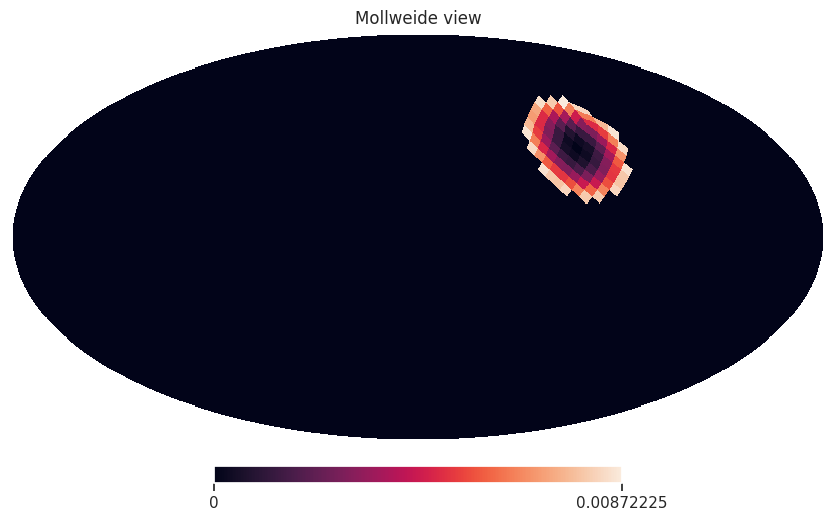

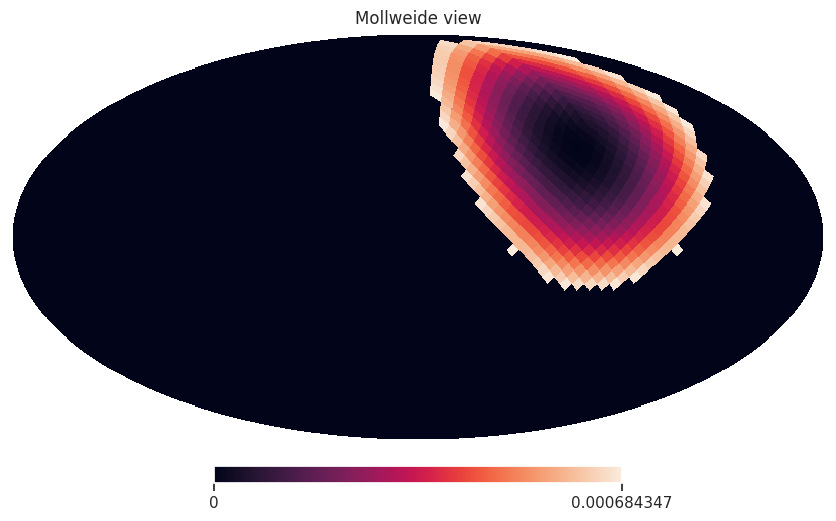

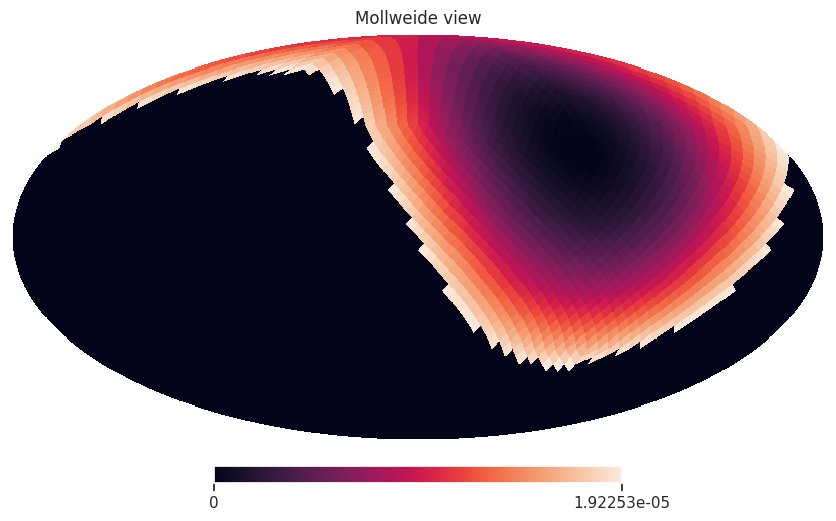

In [17]:
#Transmitter locations from the FM Transmitter database and the received power at different altitudes has not been taken into account for these plots 



FOV_400=disc[686][0]  # Overhead Hanle at an altitude of 400 km
FOV_3795=disc[686][1] # Overhead Hanle at an altitude of 400 km
FOV_36000=disc[686][2] # Overhead Hanle at an altitude of 400 km

beam_400=satellite_properties.get_beam_pattern("cos square", elev_angle[0,686,FOV_400])
beam_3795=satellite_properties.get_beam_pattern("cos square", elev_angle[1,686,FOV_3795])
beam_36000=satellite_properties.get_beam_pattern("cos square", elev_angle[2,686,FOV_36000])

data_400= np.zeros(hp.nside2npix(nside))
data_3795= np.zeros(hp.nside2npix(nside))
data_36000= np.zeros(hp.nside2npix(nside))

data_400[FOV_400]=beam_400
data_3795[FOV_3795]=beam_3795
data_36000[FOV_36000]=beam_36000

hp.mollview(data_400,flip='geo')
hp.mollview(data_3795,flip='geo')
hp.mollview(data_36000,flip='geo')

### Calculates the received RFI (FM) power using Friis Transmission equation

In [18]:
#[1] An array of values of received RFI (FM) power in dBm
#[2] An array of values of received RFI (FM) power in Kelvin 
#[3] An array of values of received RFI (FM) power in dBW
Rx_Power_in_Kelvin = Friis.calc_Friis(df, altitudes)[2]

/home/sonia/Downloads/starfire/src/Friis.py:30: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBm[j][i]= 10.*np.log10( Rx_Power[j][i])+30
/home/sonia/Downloads/starfire/src/Friis.py:32: RuntimeWarning: divide by zero encountered in log10
  Rx_Power_in_dBW[j][i]= 10.*np.log10( Rx_Power[j][i])


### Generate 3D RFI (FM) power cube

In [19]:
df_fov = power_3D_cube.get_dataframe_fov(Rx_Power_in_Kelvin, df, found_common, Rad_of_FOV, elev_angle)

In [20]:
power_output = power_3D_cube.get_power_output(npix, Rad_of_FOV, freq_range, df_fov)

### Plot RFI(FM) Power Spectrum 

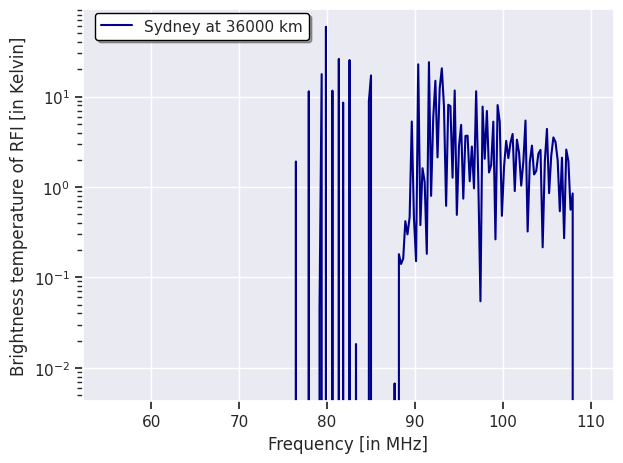

In [26]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})

plt.plot(freq_range,power_output[2,2363,:], label='Sydney at 36000 km', color='darkblue') 
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.yscale('log')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.44, 1.01),fancybox=True, shadow=True)
# plt.savefig("/home/sonia/Documents/RFI_PAPER/Sydney_36000_new.pdf")

### Plot RFI (Heatmap) 

In [40]:
power_output_sydney= plot_utils.get_PS(power_output, altitudes, nside)

Enter an altitude in km: 36000
Enter a place name: Sydney
Latitude: -33.8698439, Longitude: 151.2082848


In [43]:
power_output_x= plot_utils.get_PS(power_output, altitudes, nside)

Enter an altitude in km: 36000
Enter a place name: Bangalore
Latitude: 12.9767936, Longitude: 77.590082


In [44]:
power_output_y= plot_utils.get_PS(power_output, altitudes, nside)

Enter an altitude in km: 36000
Enter a place name: Arctic
Latitude: 42.1856379, Longitude: -75.4143448


In [45]:
power_output_p= plot_utils.get_PS(power_output, altitudes, nside)

Enter an altitude in km: 36000
Enter a place name: Pacific
Latitude: 46.5334929, Longitude: -123.768029


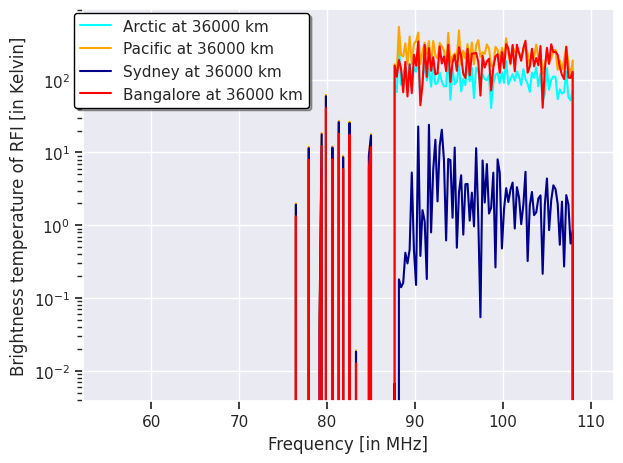

In [46]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})


plt.plot(freq_range, power_output_y,  label='Arctic at 36000 km',color="cyan")
plt.plot(freq_range, power_output_p,  label='Pacific at 36000 km',color="orange")
plt.plot(freq_range, power_output_sydney,  label='Sydney at 36000 km',color="darkblue")
plt.plot(freq_range, power_output_x,  label='Bangalore at 36000 km',color="red")
plt.yscale('log')
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.44, 1.01),fancybox=True, shadow=True)

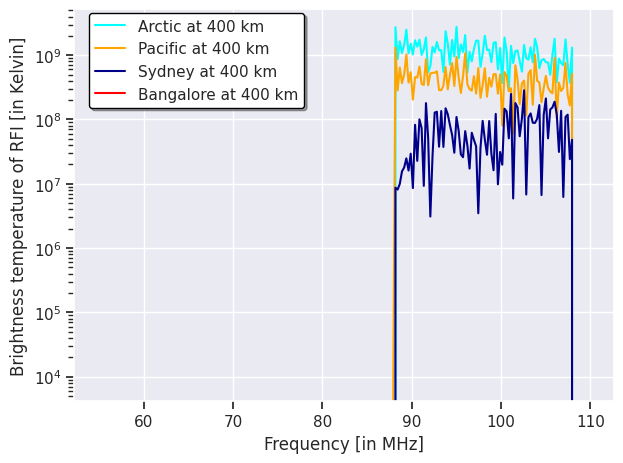

In [40]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set(rc={"xtick.bottom": True, "ytick.left": True})


plt.plot(freq_range, power_output_y,  label='Arctic at 400 km',color="cyan")
plt.plot(freq_range, power_output_p,  label='Pacific at 400 km',color="orange")
plt.plot(freq_range, power_output_sydney,  label='Sydney at 400 km',color="darkblue")
plt.plot(freq_range, power_output_x,  label='Bangalore at 400 km',color="red")
plt.yscale('log')
plt.xlabel('Frequency [in MHz]')
plt.ylabel('Brightness temperature of RFI [in Kelvin]')
plt.tight_layout()
plt.legend(facecolor="white", edgecolor="black", bbox_to_anchor=(0.44, 1.01),fancybox=True, shadow=True)

In [38]:
frequency, heatmap_400_90Mhz = plot_utils.get_heatmap(power_output, altitudes, freq_range)

Enter an altitude in km: 400
Enter the frequency: 90.1
The nearest frequency is 90.13599999999997 MHz.


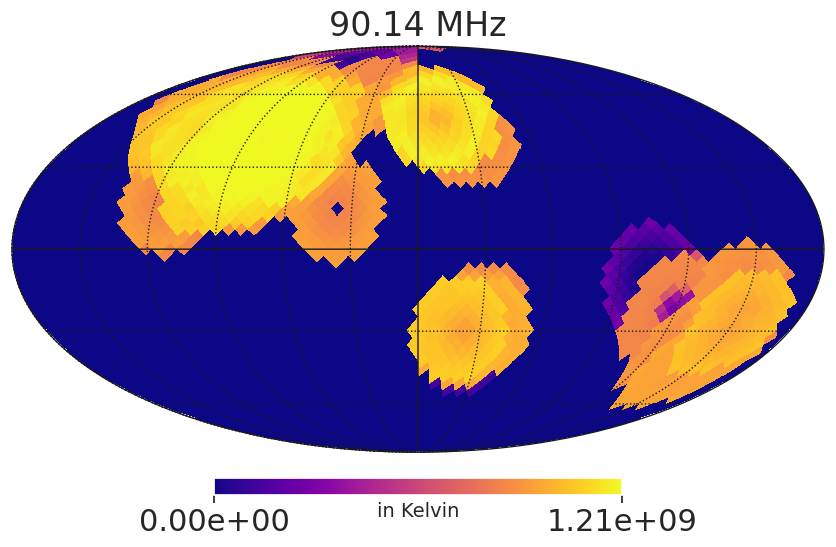

In [41]:
hp.mollview(heatmap_400_90Mhz,cmap='plasma',unit="in Kelvin",flip='geo',norm="hist",format= '%.2e',max=1.21e9, title=f"{frequency:.2f} MHz");
hp.graticule()


### Figure of Merit (FOM) calculation

In [22]:
num_of_rfi_chan=len(freq_range[power_output[0,13,:]!=0])
num_of_rfi_chan


#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)



#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=3 (Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#NUM_OF_RFI_CHANNEL=0 (Pacic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)




#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)

#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)





#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada,)

#NUM_OF_RFI_CHANNEL=83 (Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada,)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada,)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany,\n Canada)







#NUM_OF_RFI_CHANNEL=96 (Arctic Ocean at 36000 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=84 (Arctic Ocean at 3795 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA, Germany)

#NUM_OF_RFI_CHANNEL=13 (Pacific Ocean at 36000 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=3 (Paciic Ocean at 3795 km (Tokyo, USA, Germany)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA, Germany)






#NUM_OF_RFI_CHANNEL=32 (Arctic Ocean at 36000 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=12 (Arctic Ocean at 3795 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo, USA)

#NUM_OF_RFI_CHANNEL=12 (Pacific Ocean at 36000 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=2 (Paciic Ocean at 3795 km (Tokyo, USA)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo, USA)




#NUM_OF_RFI_CHANNEL=31 (Arctic Ocean at 36000 km (Tokyo)
#NUM_OF_RFI_CHANNEL=11 (Arctic Ocean at 3795 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0 (Arctic Ocean at 400 km (Tokyo)

#NUM_OF_RFI_CHANNEL=10 (Pacific Ocean at 36000 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0(Paciic Ocean at 3795 km (Tokyo)
#NUM_OF_RFI_CHANNEL=0 (Pacitic Ocean at 400 km (Tokyo)




8

In [23]:
rfi_band=244*num_of_rfi_chan # in kHz
rfi_band_inMHz=rfi_band*1e-3
rfi_band_inMHz

1.952

In [24]:
tot_band=freq_range[-1]-freq_range[0]
usable_band=tot_band-rfi_band_inMHz
usable_band


#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa)



#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia )
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia )

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia 
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia)




#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada)

#USABLE_BW=34.748000000000005(PACIFIC Ocean at 36000 km (Tokyo, USA, Germany,\n Canada,
#USABLE_BW_CHANNEL=54.268(Pacific Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, 
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, )






#USABLE_BW=31.576(Arctic Ocean at 36000 km (Tokyo, USA,, Germany)
#USABLE_BW_CHANNEL=34.504000000000005 (Arctic Ocean at 3795 km (Tokyo, USA, Germany)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA, Germany)

#USABLE_BW=51.828(Pacific Ocean at 36000 km (Tokyo, USA, Germany)
#USABLE_BW_CHANNEL=54.268(Pacifc Ocean at 3795 km (Tokyo, USA, Germany)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA, Germany)





#USABLE_BW=47.192(Arctic Ocean at 36000 km (Tokyo, USA)
#USABLE_BW_CHANNEL=52.072 (Arctic Ocean at 3795 km (Tokyo, USA)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo, USA)

#USABLE_BW=52.072(Pacific Ocean at 36000 km (Tokyo, USA)
#USABLE_BW_CHANNEL=54.512(Pacifc Ocean at 3795 km (Tokyo, USA)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo, USA)





#USABLE_BW=47.436(Arctic Ocean at 36000 km (Tokyo)
#USABLE_BW_CHANNEL=52.316 (Arctic Ocean at 3795 km (Tokyo)
#USABLE_BW=55 (Arctic Ocean at 400 km (Tokyo)

#USABLE_BW=52.56(Pacific Ocean at 36000 km (Tokyo)
#USABLE_BW_CHANNEL=55(Pacifc Ocean at 3795 km (Tokyo)
#USABLE_BW=55 (Pacific Ocean at 400 km (Tokyo)



52.94799999999995

In [25]:
time=1
FOM=time*usable_band
FOM

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia and South Africa) 55.0
#---------------------------------------------------------------------------------------------------------

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia ) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia )34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia )53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada, Australia ) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada, Australia ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada, Australia ) 55

#------------------------------------------------------------------------------------------------------------



#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,\n Canada) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany) 34.504000000000005
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany,\n Canada,) 53.048


#FOM=34.748000000000005(Pacific Ocean at 36000 km (Tokyo, USA, Germany,\n Canada) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany,\n Canada ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany,\n Canada ) 55

#---------------------------------------------------------------------------------------------------------------

#FOM=31.576(Arctic Ocean at 36000 km (Tokyo, USA, Germany,) 31.576
#FOM=34.504000000000005(Arctic Ocean at 3795 km (Tokyo, USA, Germany) 34.50
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA, Germany) 53.048


#FOM=51.828(Pacific Ocean at 36000 km (Tokyo, USA, Germany) 34.748000000000005
#FOM=54.268(Paciic Ocean at 3795 km (Tokyo, USA, Germany ) 34.748000000000005
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA, Germany) 55

#---------------------------------------------------------------------------------------------------------------


#FOM=47.192(Arctic Ocean at 36000 km (Tokyo, USA,) 31.576
#FOM=52.072(Arctic Ocean at 3795 km (Tokyo, USA) 34.992
#FOM=55(Arctic Ocean at 400 km (Tokyo, USA) 53.048


#FOM=52.072(Pacific Ocean at 36000 km (Tokyo, USA) 34.748
#FOM=54.512(Paciic Ocean at 3795 km (Tokyo, USA )34.748
#FOM=55(Pacific Ocean at 400 km (Tokyo, USA) 55

#------------------------------------------------------------------------------------------------------------


#FOM=47.436(Arctic Ocean at 36000 km (Tokyo,) 47.192
#FOM=52.316(Arctic Ocean at 3795 km (Tokyo) 52.316
#FOM=55(Arctic Ocean at 400 km (Tokyo) 55


#FOM=52.56(Pacific Ocean at 36000 km (Tokyo) 52.316
#FOM=55(Paciic Ocean at 3795 km (Tokyo ) 54.756
#FOM=55(Pacific Ocean at 400 km (Tokyo) 55

52.94799999999995